https://qiita.com/overlap/items/e7f1077ef8239f454602

In [1]:
import operator, math, random, time
import numpy as np

from deap import algorithms, base, creator, tools, gp

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# サンプルデータの生成
X, y = make_classification(n_samples=10000, n_features=10, n_informative=5, n_redundant=0, n_repeated=0,
                           n_clusters_per_class=8, random_state=123)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## lightGBM

In [3]:
import lightgbm as lgb
X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

[1]	valid_0's auc: 0.743222
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.774293
[3]	valid_0's auc: 0.786269
[4]	valid_0's auc: 0.796968
[5]	valid_0's auc: 0.798784
[6]	valid_0's auc: 0.802183
[7]	valid_0's auc: 0.802674
[8]	valid_0's auc: 0.805887
[9]	valid_0's auc: 0.810216
[10]	valid_0's auc: 0.808829
[11]	valid_0's auc: 0.812117
[12]	valid_0's auc: 0.812388
[13]	valid_0's auc: 0.813328
[14]	valid_0's auc: 0.815966
[15]	valid_0's auc: 0.815584
[16]	valid_0's auc: 0.816796
[17]	valid_0's auc: 0.819553
[18]	valid_0's auc: 0.819432
[19]	valid_0's auc: 0.820362
[20]	valid_0's auc: 0.822502
[21]	valid_0's auc: 0.823933
[22]	valid_0's auc: 0.825941
[23]	valid_0's auc: 0.826346
[24]	valid_0's auc: 0.828636
[25]	valid_0's auc: 0.829256
[26]	valid_0's auc: 0.829943
[27]	valid_0's auc: 0.830962
[28]	valid_0's auc: 0.831575
[29]	valid_0's auc: 0.83256
[30]	valid_0's auc: 0.834183
[31]	valid_0's auc: 0.835503
[32]	valid_0's auc: 0.836211
[33]	valid_0's auc: 

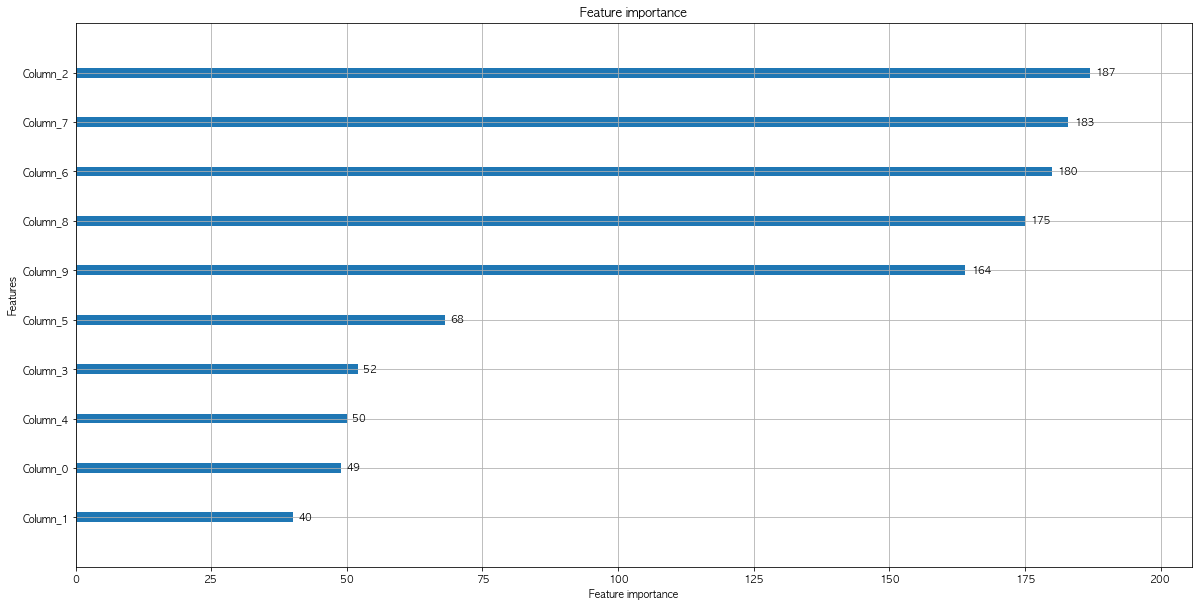

In [4]:
# データセットを生成する
lgb_train = lgb.Dataset(X_train2, y_train2)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

lgbm_params = {
    'learning_rate': 0.1,
    'num_leaves': 8,
    'boosting_type' : 'gbdt',
    'subsample' : 0.8,
    'reg_alpha' : 1,
    'reg_lambda' : 1,
    'objective': 'regression',
    'metric': 'auc',
    }

# 上記のパラメータでモデルを学習する
model = lgb.train(lgbm_params, lgb_train,
                  # モデルの評価用データを渡す
                  valid_sets=lgb_eval,
                  # 最大で 1000 ラウンドまで学習する
                  num_boost_round=1000,
                  # 10 ラウンド経過しても性能が向上しないときは学習を打ち切る
                  early_stopping_rounds=10)

# 特徴量の重要度をプロットする
lgb.plot_importance(model, figsize=(20, 10))
plt.show()

### testでの精度

In [5]:
from sklearn.metrics import roc_auc_score

# テストデータを予測する
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# auc を計算する
auc = roc_auc_score(y_test, y_pred)
print(auc)

0.854653164841


## Feature Generation by Genetic Programming

In [6]:
# ベースラインスコアの算出
clf = LogisticRegression(penalty="l2", C=1.0)
base_train_auc = np.mean(cross_val_score(clf, X_train, y_train, scoring="roc_auc", cv=5))
clf.fit(X_train, y_train)
base_test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

In [7]:
# 除算関数の定義
# 左項 / 右項で右項が0の場合1を代入する
def protectedDiv(left, right):
    eps = 1.0e-7
    tmp = np.zeros(len(left))
    tmp[np.abs(right) >= eps] = left[np.abs(right) >= eps] / right[np.abs(right) >= eps]
    tmp[np.abs(right) < eps] = 1.0
    return tmp

In [8]:
# 乱数シード
random.seed(123)

# 適合度を最大化するような木構造を個体として定義
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

In [9]:
# 初期値の計算
# 学習データの5-fold CVのAUCスコアを評価指標の初期値とする
n_features = X_train.shape[1]
clf = LogisticRegression(penalty="l2", C=1.0)
prev_auc = np.mean(cross_val_score(clf, X_train, y_train, scoring="roc_auc", cv=5))

In [10]:
# メインループ
# resultsに特徴量数、学習データのAUCスコア（5-fold CV）、テストデータのAUCスコアを保持する
# exprsに生成された特徴量の表記を保持する
results = []
exprs = []

In [11]:
for i in tqdm(range(100)):
    # 構文木として利用可能な演算の定義
    pset = gp.PrimitiveSet("MAIN", n_features)
    pset.addPrimitive(operator.add, 2)
    pset.addPrimitive(operator.sub, 2)
    pset.addPrimitive(operator.mul, 2)
    pset.addPrimitive(protectedDiv, 2)
    pset.addPrimitive(operator.neg, 1)
    pset.addPrimitive(np.cos, 1)
    pset.addPrimitive(np.sin, 1)
    pset.addPrimitive(np.tan, 1)

    # 関数のデフォルト値の設定
    toolbox = base.Toolbox()
    toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("compile", gp.compile, pset=pset)

    # 評価関数の設定
    # 新しく生成した変数を元の変数に加えて5-fold CVを求める
    def eval_genfeat(individual):
        func = toolbox.compile(expr=individual)
        features_train = [X_train[:,i] for i in range(n_features)]
        new_feat_train = func(*features_train)
        X_train_tmp = np.c_[X_train, new_feat_train]
        return np.mean(cross_val_score(clf, X_train_tmp, y_train, scoring="roc_auc", cv=5)),

    # 評価、選択、交叉、突然変異の設定
    # 選択はサイズ10のトーナメント方式、交叉は1点交叉、突然変異は深さ2のランダム構文木生成と定義
    toolbox.register("evaluate", eval_genfeat)
    toolbox.register("select", tools.selTournament, tournsize=10)
    toolbox.register("mate", gp.cxOnePoint)
    toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
    toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

    # 構文木の制約の設定
    # 交叉や突然変異で深さ5以上の木ができないようにする
    toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))
    toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5)) 

    # 世代ごとの個体とベスト解を保持するクラスの生成
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)

    # 統計量の表示設定
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", np.mean)
    mstats.register("std", np.std)
    mstats.register("min", np.min)
    mstats.register("max", np.max)

    # 進化の実行
    # 交叉確率50%、突然変異確率10%、10世代まで進化
    start_time = time.time()
    pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 10, stats=mstats, halloffame=hof, verbose=True)
    end_time = time.time()

    # ベスト解とAUCの保持
    best_expr = hof[0]
    best_auc = mstats.compile(pop)["fitness"]["max"]

    # 5-fold CVのAUCスコアが前ステップのAUCを超えていた場合
    # 生成変数を学習、テストデータに追加し、ベストAUCを更新する
    if prev_auc < best_auc:
        # 生成変数の追加
        func = toolbox.compile(expr=best_expr)
        features_train = [X_train[:,i] for i in range(n_features)]
        features_test = [X_test[:,i] for i in range(n_features)]
        new_feat_train = func(*features_train)
        new_feat_test = func(*features_test)
        X_train = np.c_[X_train, new_feat_train]
        X_test = np.c_[X_test, new_feat_test]

        ### テストAUCの計算（プロット用）
        clf.fit(X_train, y_train)
        train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
        test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

        # ベストAUCの更新と特徴量数の加算
        prev_auc = best_auc
        n_features += 1

        # 表示と出力用データの保持
        print(n_features, best_auc, train_auc, test_auc, end_time - start_time)
        results.append([n_features, best_auc, train_auc, test_auc])
        exprs.append(best_expr)

        # 変数追加後の特徴量数が30を超えた場合break
        if n_features >= 30:
            break

  0%|          | 0/100 [00:00<?, ?it/s]

   	      	                     fitness                      	              size             
   	      	--------------------------------------------------	-------------------------------
gen	nevals	avg     	max    	min     	std       	avg    	max	min	std    
0  	300   	0.741286	0.75243	0.739359	0.00093841	4.52667	14 	2  	2.84182
1  	164   	0.742463	0.759495	0.738583	0.00261917	4.43667	14 	1  	2.70666
2  	172   	0.745261	0.768907	0.740169	0.00479189	4.73   	14 	1  	3.05458
3  	171   	0.749827	0.782676	0.740549	0.00735729	5.78333	17 	1  	3.96271
4  	156   	0.75783 	0.782676	0.740453	0.0105806 	10.7967	18 	1  	4.05241
5  	168   	0.764185	0.792389	0.740825	0.0141751 	13.09  	22 	3  	2.97689
6  	167   	0.772111	0.793657	0.740836	0.016202  	15.1167	22 	6  	2.57612
7  	171   	0.775656	0.799636	0.740179	0.0174457 	14.83  	24 	4  	2.81681
8  	157   	0.782073	0.801036	0.73729 	0.0180503 	15.55  	22 	1  	2.69459
9  	166   	0.7822  	0.801207	0.739583	0.0211187 	16.2   	24 	4  	2.51131


  1%|          | 1/100 [01:21<2:13:56, 81.18s/it]

10 	164   	0.786265	0.802428	0.739242	0.021292  	16.0267	21 	1  	2.47372
11 0.802428302576 0.803795647866 0.797010138382 81.16082692146301
   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.802033	0.814404	0.761567	0.00433662	4.28333	14 	2  	2.69377
1  	164   	0.803713	0.814404	0.764503	0.00316722	4.17667	18 	1  	2.61256
2  	164   	0.806679	0.81613 	0.802141	0.0037591 	4.33   	10 	1  	1.86577
3  	161   	0.80984 	0.81613 	0.801938	0.00472126	4.64333	11 	1  	1.68012
4  	153   	0.81146 	0.81613 	0.802161	0.00515748	5.13667	11 	3  	1.38491
5  	152   	0.81188 	0.81613 	0.802048	0.00516251	5.62333	9  	1  	1.19225
6  	172   	0.811213	0.81613 	0.801716	0.00557383	5.66   	12 	1  	1.32831
7  	157   	0.811631	0.81613 	0.770352	0.00579245	5.59333	11 	1  	1.24952


  2%|▏         | 2/100 [02:53<2:18:01, 84.50s/it]

10 	147   	0.811569	0.81613 	0.80202 	0.0055067 	5.51333	13 	1  	1.31776
12 0.816129868324 0.817298780873 0.8114929688 92.24004912376404
   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.816128	0.823524	0.794877	0.00158977	4.14667	13 	2  	2.42593
1  	178   	0.817119	0.823524	0.815655	0.00180078	3.95   	13 	1  	1.9615 
2  	161   	0.819406	0.823525	0.81579 	0.00285312	4.15333	11 	1  	2.09678
3  	161   	0.820868	0.823525	0.815832	0.00317795	3.54333	12 	1  	1.74206
4  	165   	0.821452	0.823529	0.815416	0.00312237	3.97333	15 	1  	2.32364
5  	149   	0.821559	0.829063	0.815793	0.00315751	7.05   	19 	1  	3.62411
6  	167   	0.821955	0.829066	0.815815	0.00317337	10.1433	18 	1  	2.69248
7  	161   	0.823138	0.829066	0.815887	0.00383283	11.3367	21 	2  	2.93314
8 

  3%|▎         | 3/100 [04:35<2:25:12, 89.82s/it]

10 	174   	0.826045	0.829499	0.815601	0.00521858	12.1767	26 	1  	3.51835
13 0.829499139546 0.830656032717 0.824326109937 102.19790506362915
   	      	                          fitness                          	              size             
   	      	-----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std        	avg    	max	min	std    
0  	300   	0.829527	0.835429	0.828997	0.000501536	4.25667	15 	2  	2.75635
1  	175   	0.829918	0.835429	0.829007	0.000949161	3.67   	15 	1  	1.94622
2  	169   	0.830882	0.839667	0.828999	0.00179962 	3.64333	9  	1  	1.81736
3  	163   	0.832515	0.839667	0.829203	0.00270011 	5.36   	15 	1  	2.44071
4  	158   	0.834084	0.842093	0.828785	0.0036491  	5.64   	15 	1  	2.51338
5  	172   	0.836154	0.842093	0.82881 	0.00460951 	6.01   	11 	1  	1.71753
6  	160   	0.837306	0.842498	0.823182	0.00462295 	7.41667	14 	1  	2.43921
7  	162   	0.838484	0.842649	0.829118	0.00470148 	9.95667	15 	

  4%|▍         | 4/100 [06:37<2:39:13, 99.51s/it]

10 	171   	0.839536	0.842883	0.829014	0.00481196 	11.94  	19 	2  	2.41586
14 0.842882748074 0.843964157486 0.839929087385 122.11120009422302
   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.842458	0.843703	0.787594	0.00392329	4.03667	15 	2  	2.46482
1  	182   	0.842981	0.843703	0.842252	0.000256409	4.17333	14 	1  	2.45424
2  	155   	0.843284	0.845571	0.842475	0.000391736	4.08   	13 	1  	1.85839
3  	170   	0.843532	0.845629	0.842568	0.00058395 	4.82   	11 	1  	1.46319
4  	165   	0.843697	0.845777	0.757425	0.00507276 	4.49333	12 	1  	1.41302
5  	158   	0.844529	0.846178	0.842578	0.00114965 	5.07333	12 	1  	1.37403
6  	154   	0.844933	0.846178	0.842345	0.0011011  	5.38667	10 	1  	1.23982
7  	175   	0.844656	0.846526	0.759171	0.00510229 	6.36667	13 	1  

  5%|▌         | 5/100 [08:45<2:51:09, 108.10s/it]

10 	166   	0.845605	0.847932	0.756268	0.00535856 	10.24  	18 	1  	2.37678
15 0.847932485435 0.849171815009 0.844444711384 128.1265251636505
   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg 	max	min	std    
0  	300   	0.847807	0.851083	0.820355	0.00161459	4.09	14 	2  	2.33136
1  	165   	0.848223	0.851105	0.845306	0.000740776	4.52333	15 	1  	2.41028
2  	151   	0.849131	0.852687	0.847522	0.00122628 	4.5    	12 	1  	1.84481
3  	164   	0.850098	0.852687	0.847619	0.00138347 	4.13667	11 	1  	1.42524
4  	163   	0.850189	0.852687	0.847476	0.00161932 	4.82667	11 	1  	1.27408
5  	150   	0.850659	0.852687	0.847619	0.0018648  	5.15333	11 	1  	1.4685 
6  	180   	0.850297	0.852687	0.847557	0.00231168 	5.03333	14 	1  	1.65898
7  	182   	0.850447	0.852687	0.847591	0.0023277  	5.01333	13 	1  	1.6891

  6%|▌         | 6/100 [11:03<3:03:13, 116.95s/it]

10 	164   	0.850755	0.852687	0.847557	0.00232731 	4.96667	9  	1  	1.39722
16 0.852686520731 0.854126711854 0.845711008072 137.57639479637146
   	      	                     fitness                      	             size             
   	      	--------------------------------------------------	------------------------------
gen	nevals	avg     	max     	min    	std       	avg 	max	min	std   
0  	300   	0.852425	0.853307	0.79346	0.00341542	4.22	14 	2  	2.5242
1  	165   	0.852769	0.853307	0.852017	0.000182739	4.68	15 	1  	2.99849
2  	163   	0.852719	0.853331	0.801125	0.00299485 	4.71333	14 	1  	2.36033
3  	161   	0.853053	0.854913	0.85229 	0.000314936	4.28   	13 	1  	2.11067
4  	160   	0.853153	0.854983	0.852372	0.000433026	4.29667	11 	1  	2.17608
5  	178   	0.853307	0.854983	0.852255	0.000714044	6.14333	15 	1  	2.78977
6  	170   	0.853939	0.855048	0.85235 	0.00106912 	7.47667	16 	1  	2.26924
7  	165   	0.854221	0.855048	0.852372	0.00111744 	7.11   	10 	1  	1.67866
8  	165   	0.85435 	0.

  7%|▋         | 7/100 [13:48<3:23:31, 131.30s/it]

10 	188   	0.854266	0.855049	0.852362	0.00115677 	7.36333	11 	2  	1.62214
17 0.855048986868 0.85657656536 0.847930280607 164.75059580802917
   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.854564	0.855822	0.731169	0.00714094	4.14667	14 	2  	2.58299
1  	153   	0.855071	0.857286	0.839383	0.000937062	3.96667	11 	2  	2.12577
2  	162   	0.855322	0.857286	0.850464	0.000504503	4.88   	16 	1  	2.57402
3  	175   	0.855619	0.857529	0.854722	0.000635606	4.86667	13 	1  	2.12968
4  	174   	0.85604 	0.857605	0.854726	0.000952738	6.25333	14 	1  	2.76571
5  	154   	0.856475	0.857607	0.85455 	0.00108882 	8.23   	17 	1  	2.44754
6  	172   	0.856503	0.857607	0.854708	0.00118773 	9.73333	17 	1  	2.47162
7  	169   	0.856518	0.857608	0.854714	0.001217   	10.0067	19 	1  	

  8%|▊         | 8/100 [17:18<3:57:41, 155.02s/it]

10 	167   	0.856716	0.8578  	0.854715	0.00120108 	10.1267	17 	1  	2.31314
18 0.857799666473 0.859549128451 0.851489925684 210.31481289863586
   	      	                          fitness                          	              size             
   	      	-----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std        	avg    	max	min	std    
0  	300   	0.857763	0.861459	0.852446	0.000419837	4.06333	15 	2  	2.54545
1  	173   	0.858011	0.861459	0.857254	0.000633707	3.84667	18 	1  	2.43512
2  	167   	0.858658	0.861459	0.857182	0.00111542 	5.71333	18 	1  	4.18543
3  	166   	0.859848	0.861459	0.85724 	0.00149267 	4.72333	19 	1  	3.65241
4  	167   	0.860374	0.86146 	0.857317	0.00154562 	3.11333	9  	1  	0.774912
5  	167   	0.860409	0.86146 	0.85703 	0.00154042 	3.07333	8  	1  	0.669295
6  	168   	0.860277	0.86146 	0.85753 	0.00155383 	3.10333	7  	1  	0.522164
7  	172   	0.860453	0.86146 	0.857504	0.00150848 	3.07667	

  9%|▉         | 9/100 [21:27<4:37:44, 183.13s/it]

10 	160   	0.860416	0.86146 	0.824005	0.00256048 	3.09   	9  	1  	0.649538
19 0.861459640296 0.86317846929 0.85342390608 248.68981790542603
   	      	                 fitness                  	              size             
   	      	------------------------------------------	-------------------------------
gen	nevals	avg    	max     	min    	std       	avg    	max	min	std    
0  	300   	0.86124	0.862244	0.82738	0.00241753	4.11333	14 	2  	2.62941
1  	159   	0.86158	0.862736	0.860695	0.00027733	4.92667	14 	1  	2.94301
2  	177   	0.861735	0.862792	0.844961	0.00104733	5.06667	17 	1  	3.40131
3  	157   	0.861934	0.863297	0.836051	0.00157545	7.62333	16 	1  	3.45275
4  	164   	0.862149	0.864243	0.860527	0.000645915	5.88667	16 	1  	3.06602
5  	151   	0.862364	0.864243	0.860976	0.000771197	5.72   	13 	2  	2.05627
6  	174   	0.862577	0.864245	0.85769 	0.00103323 	6.21   	12 	1  	2.0492 
7  	168   	0.862926	0.864417	0.858827	0.00121661 	7.01667	15 	1  	2.51722
8  	179   	0.863138	0.864477	0.8

 10%|█         | 10/100 [26:22<5:25:13, 216.82s/it]

10 	152   	0.863318	0.864654	0.836341	0.00206684 	7.39   	15 	1  	1.63031
20 0.864653998154 0.866487796609 0.854253755846 295.38154196739197
   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.864622	0.865441	0.864099	0.00015414	3.87333	14 	2  	2.40499
1  	156   	0.86441 	0.865984	0.762702	0.00588973	4.15   	13 	1  	2.36802
2  	168   	0.864737	0.866004	0.808657	0.00327122	3.87   	15 	2  	2.00826
3  	166   	0.865119	0.866004	0.860856	0.000470518	3.09   	10 	1  	1.41959
4  	169   	0.865267	0.866004	0.860269	0.000656486	2.91667	9  	1  	1.15314
5  	178   	0.865133	0.866013	0.83921 	0.00202541 	3.67333	11 	1  	1.05513
6  	170   	0.865327	0.866013	0.860072	0.00126961 	4.10667	10 	1  	0.89179
7  	129   	0.86549 	0.866013	0.859575	0.00117117 	4.03667	8  	1  	0

 11%|█         | 11/100 [32:15<6:22:14, 257.69s/it]

10 	188   	0.865227	0.866013	0.858681	0.00153133 	4.04667	10 	1  	0.915326
21 0.866012717609 0.867726098928 0.852664128067 352.9923450946808
   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.865574	0.866715	0.753601	0.00647949	3.95333	14 	2  	2.52147
1  	151   	0.866092	0.866775	0.865552	0.000214298	3.74333	15 	1  	2.22653
2  	156   	0.866314	0.866775	0.864542	0.000349959	3.25333	11 	1  	1.85898
3  	176   	0.866591	0.866775	0.86574 	0.000282753	2.26   	8  	1  	0.886416
4  	158   	0.866532	0.866776	0.865676	0.000360715	2.71   	8  	1  	0.807816
5  	154   	0.866572	0.866777	0.86571 	0.000352942	3.04667	8  	1  	0.768866
6  	171   	0.866477	0.866778	0.86571 	0.000391157	3.10333	8  	1  	0.97262 
7  	153   	0.866549	0.866778	0.865748	0.000362031	3.10333	9  

 12%|█▏        | 12/100 [37:34<6:44:41, 275.92s/it]

10 	166   	0.86653 	0.866778	0.865714	0.000371997	3.11333	9  	1  	0.934785
22 0.866778364859 0.868600198358 0.854380886027 318.4031250476837
   	      	                      fitness                      	             size             
   	      	---------------------------------------------------	------------------------------
gen	nevals	avg     	max    	min     	std        	avg    	max	min	std   
0  	300   	0.866723	0.86719	0.866316	0.000119344	4.00667	13 	2  	2.3338
1  	169   	0.866815	0.867517	0.866346	0.000152342	4.63667	14 	1  	2.59576
2  	179   	0.866876	0.867594	0.863979	0.000317811	4.42667	14 	1  	2.536  
3  	166   	0.866945	0.867594	0.854919	0.000749558	3.90667	11 	1  	1.68264
4  	169   	0.867117	0.86807 	0.866167	0.000387287	4.55   	12 	1  	2.29074
5  	171   	0.867328	0.86807 	0.862662	0.00045752 	6.47333	14 	1  	2.75487
6  	184   	0.867435	0.868127	0.866538	0.000437682	6.85   	16 	1  	2.6244 
7  	173   	0.86761 	0.869358	0.866626	0.000579139	4.96667	16 	1  	2.89578
8  	168  

 13%|█▎        | 13/100 [43:51<7:24:19, 306.44s/it]

10 	180   	0.868132	0.869417	0.8665  	0.00102104 	5.46333	11 	1  	1.55841
23 0.8694168759 0.871426692778 0.858424026203 377.5869927406311
   	      	                          fitness                          	             size             
   	      	-----------------------------------------------------------	------------------------------
gen	nevals	avg     	max     	min     	std        	avg 	max	min	std   
0  	300   	0.869333	0.869937	0.864228	0.000370727	4.05	14 	2  	2.5886
1  	153   	0.869067	0.869937	0.748753	0.00696002 	3.82333	14 	2  	2.21783
2  	164   	0.869566	0.869937	0.854024	0.00093537 	2.93667	10 	1  	1.58514
3  	168   	0.869874	0.869937	0.86922 	0.000171076	2.14667	8  	1  	0.803216
4  	178   	0.869875	0.869937	0.86916 	0.000171566	2.16333	8  	1  	0.814446
5  	169   	0.869879	0.869937	0.869155	0.00017331 	2.08333	7  	1  	0.624277
6  	161   	0.869885	0.869937	0.868477	0.000173896	2.11333	7  	1  	0.668697
7  	169   	0.869881	0.869937	0.869245	0.000161981	2.10333	8  	1  	0.66

 14%|█▍        | 14/100 [49:46<7:39:50, 320.82s/it]

10 	156   	0.869882	0.869937	0.869157	0.000163253	2.12333	7  	1  	0.664421
24 0.869937428082 0.872046656471 0.858455057979 354.31483483314514
   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg 	max	min	std    
0  	300   	0.869664	0.870283	0.819549	0.00293885	4.06	15 	2  	2.57224
1  	168   	0.86997 	0.870283	0.869491	0.000136344	3.4 	10 	1  	1.70294
2  	181   	0.870036	0.870663	0.869531	0.000190518	3.67333	9  	1  	1.66932
3  	188   	0.869007	0.870663	0.54096 	0.0189728  	4.48   	11 	1  	1.93811
4  	156   	0.868964	0.870684	0.490688	0.02188    	5.42667	12 	1  	1.90909
5  	172   	0.870318	0.870691	0.865306	0.000537014	6.16   	12 	1  	1.53441
6  	164   	0.870332	0.870781	0.86341 	0.000765505	5.53333	11 	1  	1.37679
7  	171   	0.870418	0.87081 	0.869713	0.000370474	4.9    	11 	1  	1.51327

 15%|█▌        | 15/100 [56:47<8:16:57, 350.80s/it]

10 	178   	0.870293	0.871088	0.795834	0.0043251  	10.04  	19 	1  	2.5778 
25 0.8710876351 0.873208643065 0.860753411493 420.68731713294983
   	      	                     fitness                      	              size             
   	      	--------------------------------------------------	-------------------------------
gen	nevals	avg    	max     	min     	std       	avg 	max	min	std    
0  	300   	0.87072	0.871573	0.775945	0.00548234	4.24	14 	2  	2.67377
1  	168   	0.871118	0.871621	0.868214	0.000231546	4.69	14 	1  	2.92357
2  	161   	0.869894	0.871621	0.728686	0.0122212  	5.98667	13 	1  	3.13472
3  	159   	0.866156	0.871815	0.496168	0.0371511  	7.09333	14 	1  	2.46129
4  	166   	0.863228	0.871817	0.496168	0.0458803  	6.04   	14 	2  	2.38853
5  	169   	0.871479	0.872009	0.870773	0.000322956	4.14333	10 	1  	1.07523
6  	150   	0.871587	0.872016	0.870773	0.000347815	3.95667	8  	1  	1.0808 
7  	191   	0.871255	0.872016	0.787578	0.00485468 	4.11667	9  	1  	1.13859
8  	157   	0.871621	

 16%|█▌        | 16/100 [1:04:13<8:51:08, 379.39s/it]

10 	160   	0.871736	0.87212 	0.870754	0.000401721	5.33333	10 	3  	1.37679
26 0.872120329445 0.874251249615 0.860497149081 446.03529500961304
   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.871952	0.872388	0.844608	0.00159558	3.99667	15 	2  	2.70986
1  	170   	0.872079	0.87261 	0.858097	0.00082847	4.20333	19 	1  	2.47427
2  	166   	0.872195	0.87261 	0.871479	0.000177403	3.45   	14 	1  	2.02011
3  	159   	0.872257	0.87261 	0.871769	0.00020992 	3.30667	9  	1  	1.58513
4  	161   	0.872328	0.872924	0.869782	0.000307733	4.89333	10 	1  	1.74412
5  	160   	0.872409	0.872924	0.871766	0.000317778	5.90667	12 	1  	1.5159 
6  	164   	0.872513	0.872924	0.871537	0.000376167	5.93667	13 	1  	1.57881
7  	163   	0.872625	0.872924	0.87137 	0.000399094	6.07667	12 	2  	

 17%|█▋        | 17/100 [1:11:42<9:13:47, 400.34s/it]

10 	171   	0.87266 	0.872924	0.870762	0.000400823	5.99667	15 	1  	1.42478
27 0.872923635008 0.875051970946 0.86098064418 449.14445900917053
   	      	                      fitness                      	              size             
   	      	---------------------------------------------------	-------------------------------
gen	nevals	avg    	max     	min     	std        	avg    	max	min	std    
0  	300   	0.87282	0.873334	0.870583	0.000200191	4.05333	14 	2  	2.51869
1  	164   	0.872921	0.87348 	0.872455	0.000122134	4.54   	14 	1  	2.75954
2  	174   	0.871751	0.873488	0.508188	0.0210266  	6.30333	17 	1  	3.25955
3  	161   	0.87306 	0.873488	0.870661	0.000285023	6.63   	17 	1  	2.99551
4  	181   	0.873098	0.873488	0.872232	0.000322762	5.37333	18 	2  	2.67469
5  	162   	0.873175	0.873491	0.862047	0.000725667	4.21333	14 	1  	1.12598
6  	163   	0.873205	0.873491	0.866599	0.000506145	4.03667	9  	1  	0.869093
7  	166   	0.873198	0.873492	0.872542	0.000348138	4.05   	11 	1  	0.849019
8  	

 18%|█▊        | 18/100 [1:19:33<9:36:03, 421.50s/it]

10 	158   	0.873236	0.873496	0.872527	0.000330624	4.11   	10 	3  	0.760197
28 0.873495655487 0.875755438167 0.861473148504 470.81135058403015
   	      	                      fitness                      	              size             
   	      	---------------------------------------------------	-------------------------------
gen	nevals	avg   	max     	min     	std        	avg    	max	min	std    
0  	300   	0.8734	0.874088	0.857579	0.000922923	3.86333	13 	2  	2.19043
1  	174   	0.873193	0.874088	0.777559	0.00553349 	3.85333	10 	1  	1.81984
2  	162   	0.873617	0.874101	0.872522	0.000236797	3.61333	11 	1  	1.60535
3  	153   	0.873548	0.874117	0.813262	0.00349991 	4.09667	9  	2  	1.49911
4  	173   	0.873835	0.874123	0.873085	0.000352327	4.81   	12 	1  	1.85128
5  	165   	0.873788	0.874123	0.853776	0.00122965 	5.51333	11 	1  	2.17175
6  	163   	0.873771	0.874126	0.843375	0.00178737 	6.94667	15 	1  	1.45046
7  	169   	0.873914	0.874126	0.873034	0.000319155	7.15667	14 	1  	1.29053
8  	17

 19%|█▉        | 19/100 [1:28:30<10:15:43, 456.09s/it]

10 	158   	0.873935	0.87417 	0.872638	0.000312879	9.11333	15 	1  	1.84404
29 0.874169694807 0.87644046711 0.861510186431 536.7007830142975
   	      	                     fitness                      	              size             
   	      	--------------------------------------------------	-------------------------------
gen	nevals	avg    	max     	min     	std       	avg 	max	min	std    
0  	300   	0.87347	0.874464	0.763249	0.00720991	3.74	14 	2  	2.25516
1  	173   	0.873701	0.874724	0.767308	0.00642646	3.83333	12 	1  	2.15071
2  	170   	0.874204	0.874732	0.866589	0.000514518	3.89   	10 	2  	1.63439
3  	159   	0.874194	0.874732	0.836526	0.00218975 	3.65   	9  	1  	1.09278
4  	179   	0.874368	0.874734	0.872428	0.000302147	3.80667	9  	1  	0.970887
5  	170   	0.874507	0.874734	0.873641	0.000306773	4.06   	9  	1  	0.745922
6  	169   	0.874476	0.874734	0.873922	0.000313726	4.07667	10 	1  	0.957839
7  	163   	0.874347	0.874734	0.825061	0.00286728 	4.08667	9  	1  	0.791089
8  	175   	0.8

In [12]:
# 結果の出力
print()
print("### Results")
print("Baseline AUC train :", base_train_auc)
print("Baseline AUC test :", base_test_auc)
print("Best AUC train :", results[-1][1])
print("Best AUC test :", results[-1][3])


### Results
Baseline AUC train : 0.741195900486
Baseline AUC test : 0.731194743417
Best AUC train : 0.874734038742
Best AUC test : 0.861353025498


In [13]:
# 結果のプロット
res = np.array(results)
plt.plot(res[:,0], res[:,1],"o-", color="b", label="train(5-fold CV)")
plt.plot(res[:,0], res[:,3],"o-", color="r", label="test")
plt.plot(10, base_train_auc, "d", color="b", label = "train baseline(5-fold CV)")
plt.plot(10, base_test_auc, "d", color="r", label = "test baseline")
plt.xlim(9,31)
plt.grid(which="both")
plt.xlabel('n_features')
plt.ylabel('AUC')
plt.legend(loc="lower right")
plt.savefig("gp_featgen.png")

In [14]:
# 生成した構文木の出力
print()
print("### Generated feature expression")
for expr in exprs:
    print(expr)


### Generated feature expression
mul(sub(add(mul(ARG9, ARG2), cos(neg(ARG6))), neg(ARG6)), sub(ARG7, cos(cos(neg(ARG6)))))
mul(neg(ARG10), mul(ARG9, ARG8))
sub(add(ARG1, ARG8), add(mul(add(ARG2, ARG6), ARG8), cos(protectedDiv(ARG10, ARG3))))
sub(sub(sub(neg(mul(ARG9, ARG12)), cos(ARG9)), cos(ARG9)), mul(ARG2, ARG12))
mul(add(add(ARG6, neg(ARG7)), ARG8), add(sin(ARG6), neg(ARG7)))
sin(cos(add(ARG8, ARG2)))
cos(cos(add(cos(ARG9), sin(sin(ARG2)))))
mul(sub(ARG10, mul(mul(ARG7, ARG2), cos(ARG6))), ARG16)
mul(ARG14, ARG8)
mul(sub(sub(ARG14, ARG9), sin(ARG6)), add(ARG9, ARG2))
mul(ARG11, cos(ARG16))
sin(cos(ARG7))
mul(add(cos(ARG9), tan(ARG21)), ARG8)
cos(ARG22)
mul(sub(ARG23, ARG21), sub(sin(ARG9), add(sub(sin(ARG9), add(ARG13, ARG3)), ARG3)))
mul(add(add(ARG21, neg(neg(ARG16))), ARG2), ARG23)
mul(ARG2, neg(mul(ARG9, ARG9)))
mul(cos(ARG14), ARG26)
sub(mul(mul(cos(ARG13), ARG0), ARG26), mul(ARG17, ARG26))
mul(cos(ARG6), ARG2)


## lightGBM(2)

[1]	valid_0's auc: 0.752588
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.770969
[3]	valid_0's auc: 0.791902
[4]	valid_0's auc: 0.796553
[5]	valid_0's auc: 0.79827
[6]	valid_0's auc: 0.80239
[7]	valid_0's auc: 0.807133
[8]	valid_0's auc: 0.812738
[9]	valid_0's auc: 0.813093
[10]	valid_0's auc: 0.816273
[11]	valid_0's auc: 0.822135
[12]	valid_0's auc: 0.821824
[13]	valid_0's auc: 0.824187
[14]	valid_0's auc: 0.825901
[15]	valid_0's auc: 0.827086
[16]	valid_0's auc: 0.830691
[17]	valid_0's auc: 0.833257
[18]	valid_0's auc: 0.835706
[19]	valid_0's auc: 0.837942
[20]	valid_0's auc: 0.839303
[21]	valid_0's auc: 0.840747
[22]	valid_0's auc: 0.842322
[23]	valid_0's auc: 0.843171
[24]	valid_0's auc: 0.844819
[25]	valid_0's auc: 0.845503
[26]	valid_0's auc: 0.846534
[27]	valid_0's auc: 0.847227
[28]	valid_0's auc: 0.848505
[29]	valid_0's auc: 0.848983
[30]	valid_0's auc: 0.849424
[31]	valid_0's auc: 0.850356
[32]	valid_0's auc: 0.85121
[33]	valid_0's auc: 0.

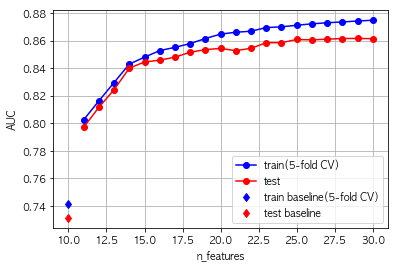

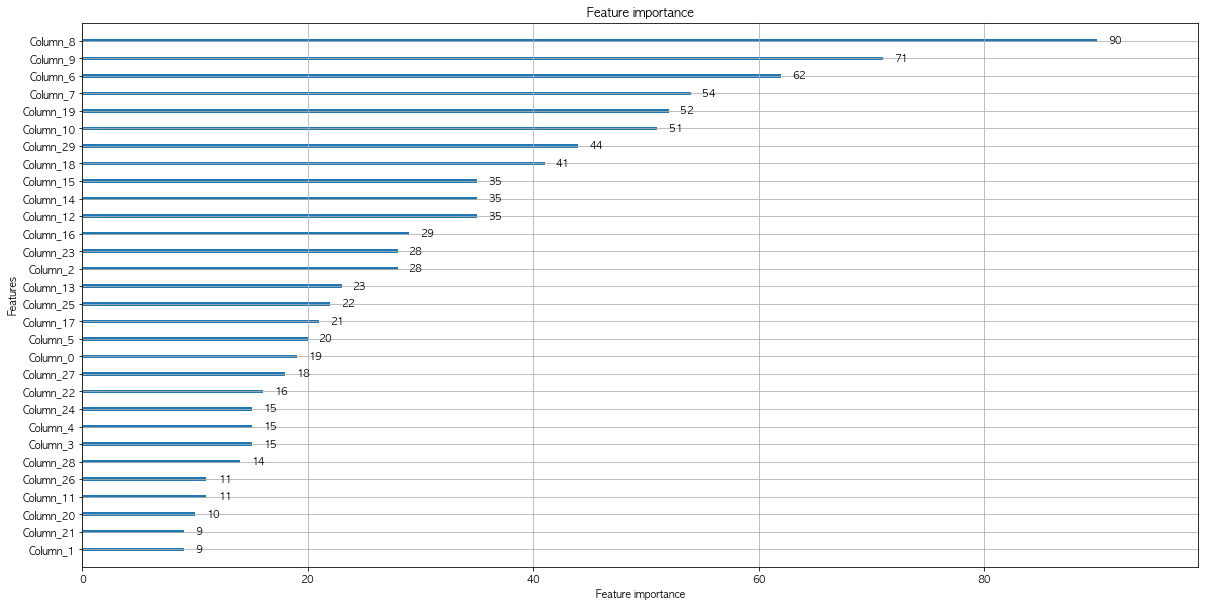

In [15]:
X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

# データセットを生成する
lgb_train = lgb.Dataset(X_train2, y_train2)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

lgbm_params = {
    'learning_rate': 0.1,
    'num_leaves': 8,
    'boosting_type' : 'gbdt',
    'subsample' : 0.8,
    'reg_alpha' : 1,
    'reg_lambda' : 1,
    'objective': 'regression',
    'metric': 'auc',
    }

# 上記のパラメータでモデルを学習する
model2 = lgb.train(lgbm_params, lgb_train,
                  # モデルの評価用データを渡す
                  valid_sets=lgb_eval,
                  # 最大で 1000 ラウンドまで学習する
                  num_boost_round=1000,
                  # 10 ラウンド経過しても性能が向上しないときは学習を打ち切る
                  early_stopping_rounds=10)

# 特徴量の重要度をプロットする
lgb.plot_importance(model2, figsize=(20, 10))
plt.show()

### testでの検証

In [16]:
# テストデータを予測する
y_pred = model2.predict(X_test, num_iteration=model2.best_iteration)

# auc を計算する
auc = roc_auc_score(y_test, y_pred)
print(auc)

0.877752818887
